# GAN to generate images of MNIST dataset

In [0]:
import numpy as np
from tqdm import tqdm   # to display progress bar
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from keras.layers import Input,Dense,Dropout,Flatten, LeakyReLU
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [0]:
np.random.seed(1000)

In [0]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
X_train=(x_train.astype(np.float32) - 127.5)/127.5  # to convert pixel values between (-1,1)
print(X_train.shape)

(60000, 28, 28)


In [0]:
X_train=X_train.reshape(-1,28*28)

In [0]:
X_train.shape

(60000, 784)

In [0]:
adam=Adam(lr=0.0002, beta_1=0.5)

In [0]:
generator=Sequential()
generator.add(Dense(256, input_dim=(100))) #10*10
generator.add(LeakyReLU(0.2))


generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

generator.add(Dense(784, activation='tanh')) #tanh gives -1 to 1 
generator.compile(loss="binary_crossentropy", optimizer=adam)
generator.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_____________________

In [0]:
discriminator=Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer=adam)

discriminator.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
____

In [0]:
discriminator.trainable=False
ganInput=Input(shape=(100,))
x=generator(ganInput)
ganOutput=discriminator(x)

gan=Model(input=ganInput, output=ganOutput)
gan.compile(loss="binary_crossentropy", optimizer=adam)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [0]:
def generateAndPlot():
  num_examples=100
  noise=np.random.normal(0,1,size=[num_examples, 100])
  generatedImages= generator.predict(noise)
  generatedImages= generatedImages.reshape(num_examples,28,28)

  plt.figure(figsize=(10,10))
  for i in range(num_examples):
    plt.subplot(10,10,i+1)
    plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')

    plt.axis('off')
  plt.show()
                      
  
      

In [0]:
def train(epochs=1, batch_size=128):
  m=X_train.shape[0]
  batchCount=m//batch_size
  generateAndPlot()


  for e in range(epochs):
    print(f"Epoch: {e}")
    for _ in tqdm(range(batchCount)):
      noise=np.random.normal(0,1,size=[batch_size, 100])
      generatedImages= generator.predict(noise)
      
      imageBatch=X_train[np.random.randint(0,m,size=batch_size)]

      X=np.concatenate([imageBatch, generatedImages])
      yDis=np.zeros(2*batch_size)
      yDis[:batch_size]=0.9 # instead of 1 due to overfitting, this tech known as one-sided label smoothing

      discriminator.trainable=True
      dLoss=discriminator.train_on_batch(X,yDis)
      discriminator.trainable=False

      noise=np.random.normal(0,1,size=[batch_size, 100])
      yGan=np.ones(batch_size)
      gLoss=gan.train_on_batch(noise,yGan)

    if e%10==0:
      generateAndPlot()



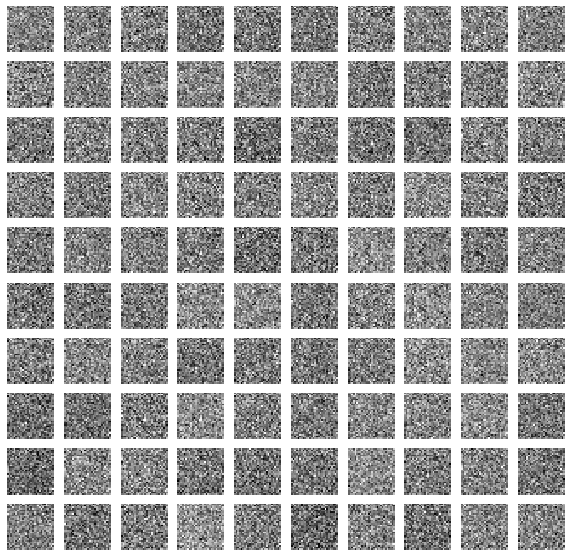

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 0




100%|██████████| 468/468 [00:13<00:00, 35.71it/s]


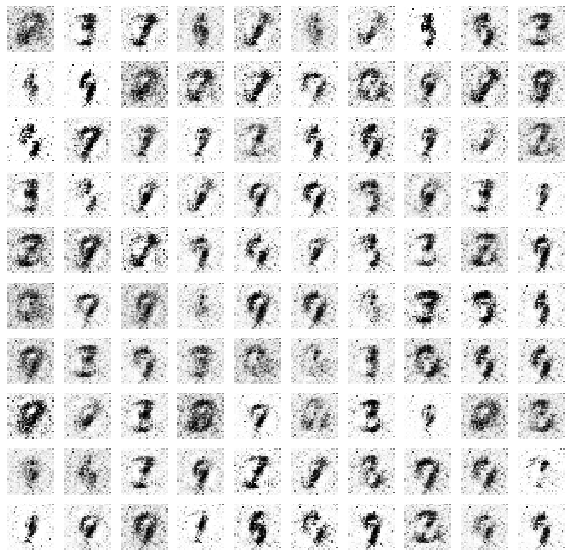

  1%|          | 3/468 [00:00<00:15, 29.90it/s]

Epoch: 1


  1%|          | 4/468 [00:00<00:11, 39.09it/s]

Epoch: 2


  1%|          | 5/468 [00:00<00:10, 42.42it/s]

Epoch: 3


  1%|          | 5/468 [00:00<00:11, 41.71it/s]

Epoch: 4


  1%|          | 5/468 [00:00<00:10, 43.34it/s]

Epoch: 5


  1%|          | 5/468 [00:00<00:10, 43.99it/s]

Epoch: 6


  1%|          | 5/468 [00:00<00:11, 41.95it/s]

Epoch: 7


  1%|          | 5/468 [00:00<00:10, 42.60it/s]

Epoch: 8


  1%|          | 5/468 [00:00<00:10, 42.65it/s]

Epoch: 9


  1%|          | 5/468 [00:00<00:10, 43.87it/s]

Epoch: 10


100%|██████████| 468/468 [00:10<00:00, 42.66it/s]


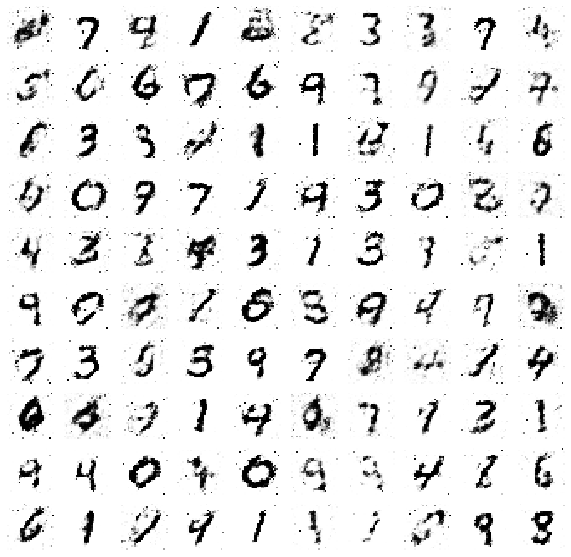

  1%|          | 4/468 [00:00<00:13, 33.67it/s]

Epoch: 11


  1%|          | 5/468 [00:00<00:10, 44.11it/s]

Epoch: 12


  1%|          | 5/468 [00:00<00:10, 43.65it/s]

Epoch: 13


  1%|          | 5/468 [00:00<00:10, 43.08it/s]

Epoch: 14


  1%|          | 5/468 [00:00<00:10, 43.88it/s]

Epoch: 15


  1%|          | 5/468 [00:00<00:11, 41.45it/s]

Epoch: 16


  1%|          | 5/468 [00:00<00:10, 44.42it/s]

Epoch: 17


  1%|          | 5/468 [00:00<00:11, 42.02it/s]

Epoch: 18


  1%|          | 5/468 [00:00<00:10, 43.63it/s]

Epoch: 19


  1%|          | 5/468 [00:00<00:11, 41.81it/s]

Epoch: 20


100%|██████████| 468/468 [00:10<00:00, 42.83it/s]


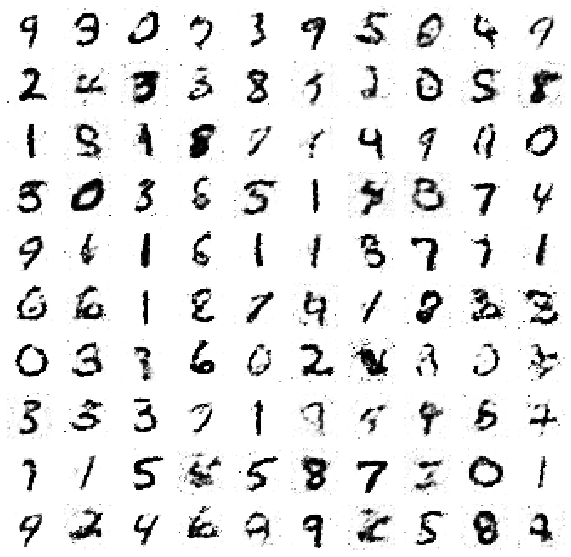

  1%|          | 4/468 [00:00<00:12, 36.77it/s]

Epoch: 21


  1%|          | 5/468 [00:00<00:11, 41.71it/s]

Epoch: 22


  1%|          | 5/468 [00:00<00:10, 42.97it/s]

Epoch: 23


  1%|          | 5/468 [00:00<00:10, 45.19it/s]

Epoch: 24


  1%|          | 5/468 [00:00<00:10, 45.00it/s]

Epoch: 25


  1%|          | 5/468 [00:00<00:10, 43.94it/s]

Epoch: 26


  1%|          | 5/468 [00:00<00:10, 43.64it/s]

Epoch: 27


  1%|          | 5/468 [00:00<00:10, 44.38it/s]

Epoch: 28


  1%|          | 5/468 [00:00<00:10, 43.96it/s]

Epoch: 29


  1%|          | 5/468 [00:00<00:10, 44.00it/s]

Epoch: 30


100%|██████████| 468/468 [00:10<00:00, 42.87it/s]


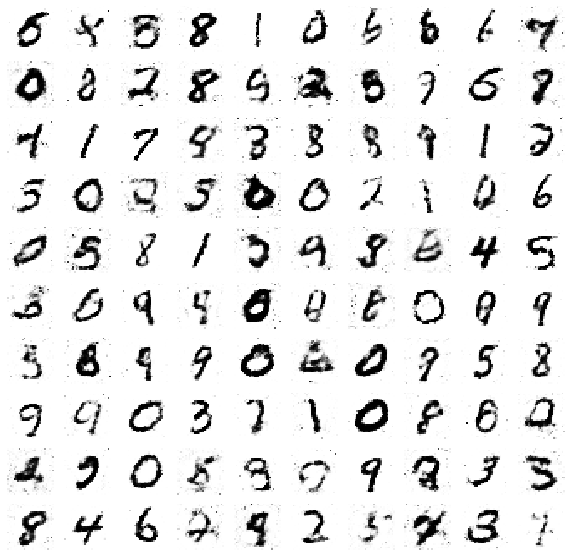

  1%|          | 4/468 [00:00<00:12, 37.82it/s]

Epoch: 31


  1%|          | 5/468 [00:00<00:10, 42.37it/s]

Epoch: 32


  1%|          | 5/468 [00:00<00:10, 43.66it/s]

Epoch: 33


  1%|          | 5/468 [00:00<00:10, 42.93it/s]

Epoch: 34


  1%|          | 5/468 [00:00<00:11, 41.99it/s]

Epoch: 35


  1%|          | 5/468 [00:00<00:10, 44.04it/s]

Epoch: 36


  1%|          | 5/468 [00:00<00:10, 43.26it/s]

Epoch: 37


  1%|          | 5/468 [00:00<00:10, 43.67it/s]

Epoch: 38


  1%|          | 5/468 [00:00<00:10, 43.80it/s]

Epoch: 39


  1%|          | 5/468 [00:00<00:10, 43.14it/s]

Epoch: 40


100%|██████████| 468/468 [00:10<00:00, 43.01it/s]


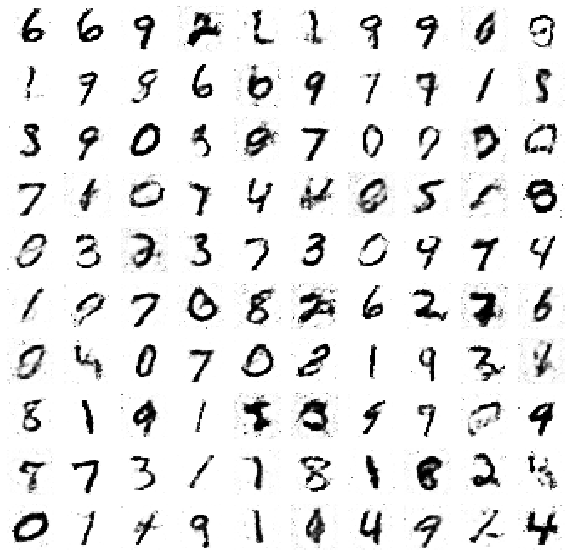

  1%|          | 4/468 [00:00<00:13, 34.05it/s]

Epoch: 41


  1%|          | 5/468 [00:00<00:11, 42.06it/s]

Epoch: 42


  1%|          | 5/468 [00:00<00:10, 43.57it/s]

Epoch: 43


  1%|          | 5/468 [00:00<00:10, 43.14it/s]

Epoch: 44


  1%|          | 5/468 [00:00<00:10, 44.56it/s]

Epoch: 45


  1%|          | 5/468 [00:00<00:10, 44.84it/s]

Epoch: 46


  1%|          | 5/468 [00:00<00:10, 43.03it/s]

Epoch: 47


  1%|          | 5/468 [00:00<00:10, 42.56it/s]

Epoch: 48


  1%|          | 5/468 [00:00<00:10, 43.12it/s]

Epoch: 49


100%|██████████| 468/468 [00:10<00:00, 42.72it/s]


In [0]:
train(50)